# Import Librarys and Files

## Imports

### Add top level to the import path

In [1]:
import sys
import os

# Add the project root to sys.path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

### Import some classes/modules we'll be using

In [2]:
import ROOT as r
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from tqdm.notebook import tqdm 

import utils.utils as utils
import utils.plotting_utils as plotting_utils
from models.event_patterns import EventPatterns
from models.pattern import Pattern
from models.vertex import Vertex
from models.tracklet import Tracklet
from models.hit import Hit

## Load Shared libraries to access methods of ROOT objects in python

In [3]:
PI_ROOT_DICT_PATH = "/home/jack/large_projects/simulation/install/lib/libPiRootDict.so" #Change to match system path
r.gSystem.Load(PI_ROOT_DICT_PATH)

0

## Load Pattern finding truth data
This also contains what we need to reconstruct patterns. So it gives validation (true patterns) and a method to create our own pattern

In [4]:
rec_file_path = "/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/all_rec_pienu_tracklets.root"
truth_rec_file_path = "/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/all_rec_pienu_tracklets_truth.root"

# Print creation times
utils.print_file_creation_time(rec_file_path)
utils.print_file_creation_time(truth_rec_file_path)

# Open the files
rec_file = r.TFile(rec_file_path, "READ")
truth_rec_file = r.TFile(truth_rec_file_path, "READ")


The file '/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/all_rec_pienu_tracklets.root' was created on: 2025-04-22 14:38:37
The file '/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/all_rec_pienu_tracklets_truth.root' was created on: 2025-04-23 14:49:27


## Get ROOT objects from our file
Making these more than once can cause memory leaks

In [5]:
tree = rec_file.Get("rec")
truth_tree = truth_rec_file.Get("rec")
geoHelper = rec_file.Get("GeoHeader")

## (Optional) Validate the file

In [6]:
print(f"Entries: {tree.GetEntries()}")

tree.GetEntry(0)  # Load the first entry

vec_names = [branch.GetName() for branch in tree.GetListOfBranches()]
print("Branches:")
print(vec_names)

for name in vec_names:
    vec = getattr(tree, name)
    print(f"\n{name} (size = {len(vec)}):")
    for i, item in enumerate(vec):
        print(f"  [{i}] {item}")


Entries: 58403
Branches:
['infoVec', 'dtarHitsVec', 'atarHitsVec', 'trackerHitsVec', 'caloHitsVec', 'tagVec', 'summaryVec', 'patternVec', 'trackletVec', 'clusterVec']

infoVec (size = 1):
  [0] Name: PIMCInfo Title: 

dtarHitsVec (size = 1):
  [0] Name: PIRECTrackletHit Title: 

atarHitsVec (size = 51):
  [0] Name: PIRECTrackletHit Title: 
  [1] Name: PIRECTrackletHit Title: 
  [2] Name: PIRECTrackletHit Title: 
  [3] Name: PIRECTrackletHit Title: 
  [4] Name: PIRECTrackletHit Title: 
  [5] Name: PIRECTrackletHit Title: 
  [6] Name: PIRECTrackletHit Title: 
  [7] Name: PIRECTrackletHit Title: 
  [8] Name: PIRECTrackletHit Title: 
  [9] Name: PIRECTrackletHit Title: 
  [10] Name: PIRECTrackletHit Title: 
  [11] Name: PIRECTrackletHit Title: 
  [12] Name: PIRECTrackletHit Title: 
  [13] Name: PIRECTrackletHit Title: 
  [14] Name: PIRECTrackletHit Title: 
  [15] Name: PIRECTrackletHit Title: 
  [16] Name: PIRECTrackletHit Title: 
  [17] Name: PIRECTrackletHit Title: 
  [18] Name: PIRECTra

# Create Python Structure from Event Data

## Initialize Event Patterns Object

In [7]:
# Initialize Event patterns without tracklet, vertex, and pattern forming algorithms (we'll add them later)
event_index = 0
event_patterns = EventPatterns(event_index, None, None, None, validator = None)

# For "normal use" you'd just initialize with all 3 pattern forming algorithms here, then call event_patterns.form_all(file, index)
# Below, we go through each step instead:


## Create tracklets for an event

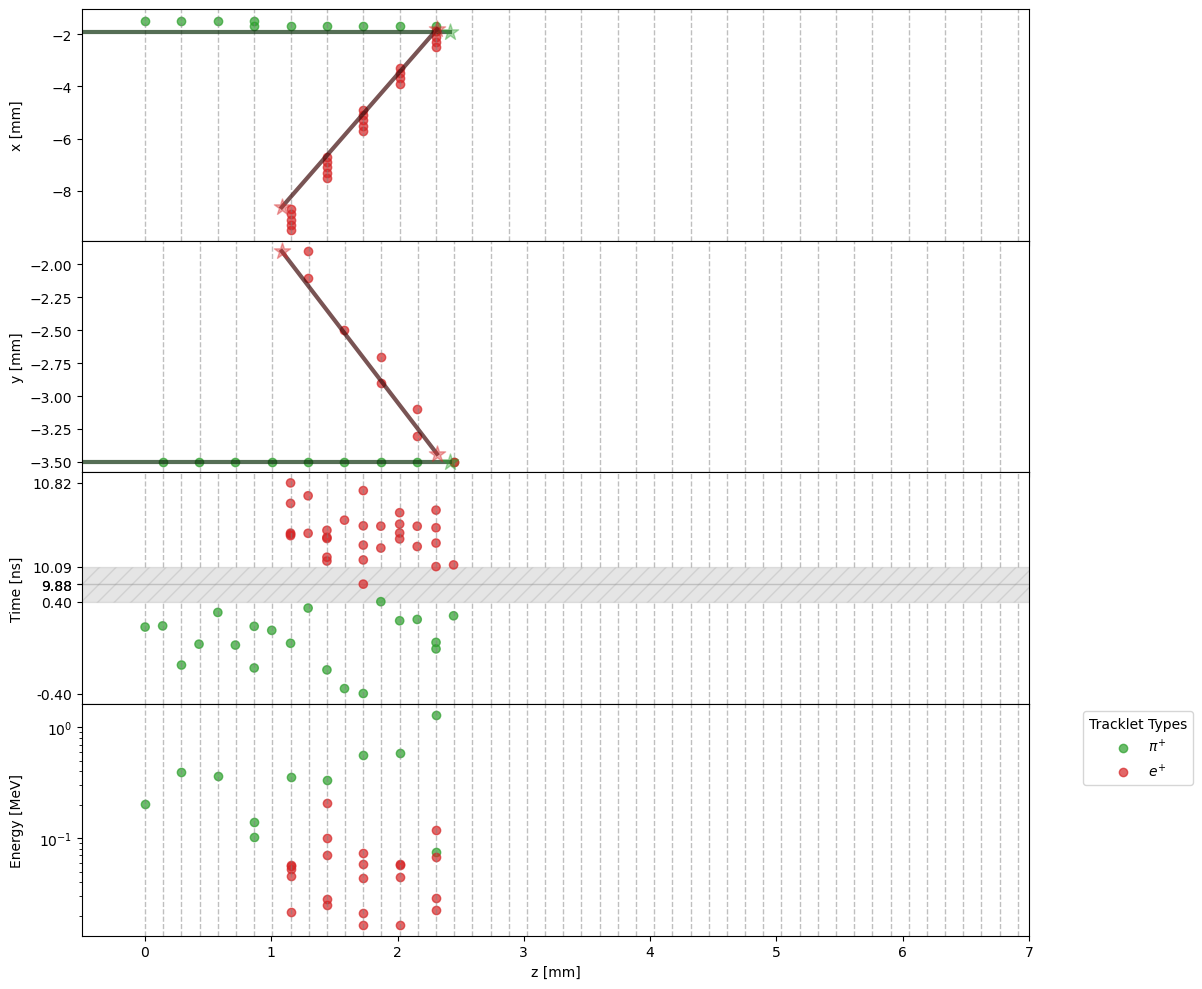

Total unique tracklets: 2
Tracklet 0:
  Endpoint 0: Point3D(x=-1.4463343697395248, y=-3.3926687394790496, z=-34803145791889.43)
  Endpoint 1: Point3D(x=-1.9168086876196897, y=-3.499999999999979, z=2.41649002701341)
Tracklet 1:
  Endpoint 0: Point3D(x=-8.623605629023437, y=-1.8999999761583466, z=1.0825000000000002)
  Endpoint 1: Point3D(x=-1.8163632585610665, y=-3.4390920175030497, z=2.311747027719356)
Extra event info:
{'stage': <Stage.TRACKLETS_FORMED: 1>, 'tracklet_algorithm_info': {'n_patterns_truth': 1, 'particles_in_event_truth': Counter({211: 1, -11: 1}), 'patterns_truth': {0: [0, 1]}}}


In [8]:
# Choose a tracklet forming algorithm, I'm use this default one, but you can write your own child class of TrackletFormer
import algorithms.tracklet.reconstructed_tracklet_former
reload(algorithms.tracklet.reconstructed_tracklet_former)

from algorithms.tracklet.reconstructed_tracklet_former import ReconstructedTrackletFormer
event_patterns.tracklet_former = ReconstructedTrackletFormer(truth_tree)
event_patterns.form_tracklets(tree, geoHelper, event_index)

# Plot the tracklets
reload(plotting_utils)
plotting_utils.plot_event(event_patterns)

unique_tracklets = {
    tracklet
    for pattern in event_patterns.get_patterns()
    for vertex in pattern.get_vertices()
    for tracklet in vertex.get_tracklets()
}

print(f"Total unique tracklets: {len(unique_tracklets)}")
for i, tracklet in enumerate(unique_tracklets):
    endpoint_0, endpoint_1 = tracklet.get_endpoints()
    print(f"Tracklet {i}:")
    print(f"  Endpoint 0: {endpoint_0}")
    print(f"  Endpoint 1: {endpoint_1}")


# See the extra info stored at this point
print("Extra event info:")
print(event_patterns.extra_info)

## Create Vertices from Tracklets

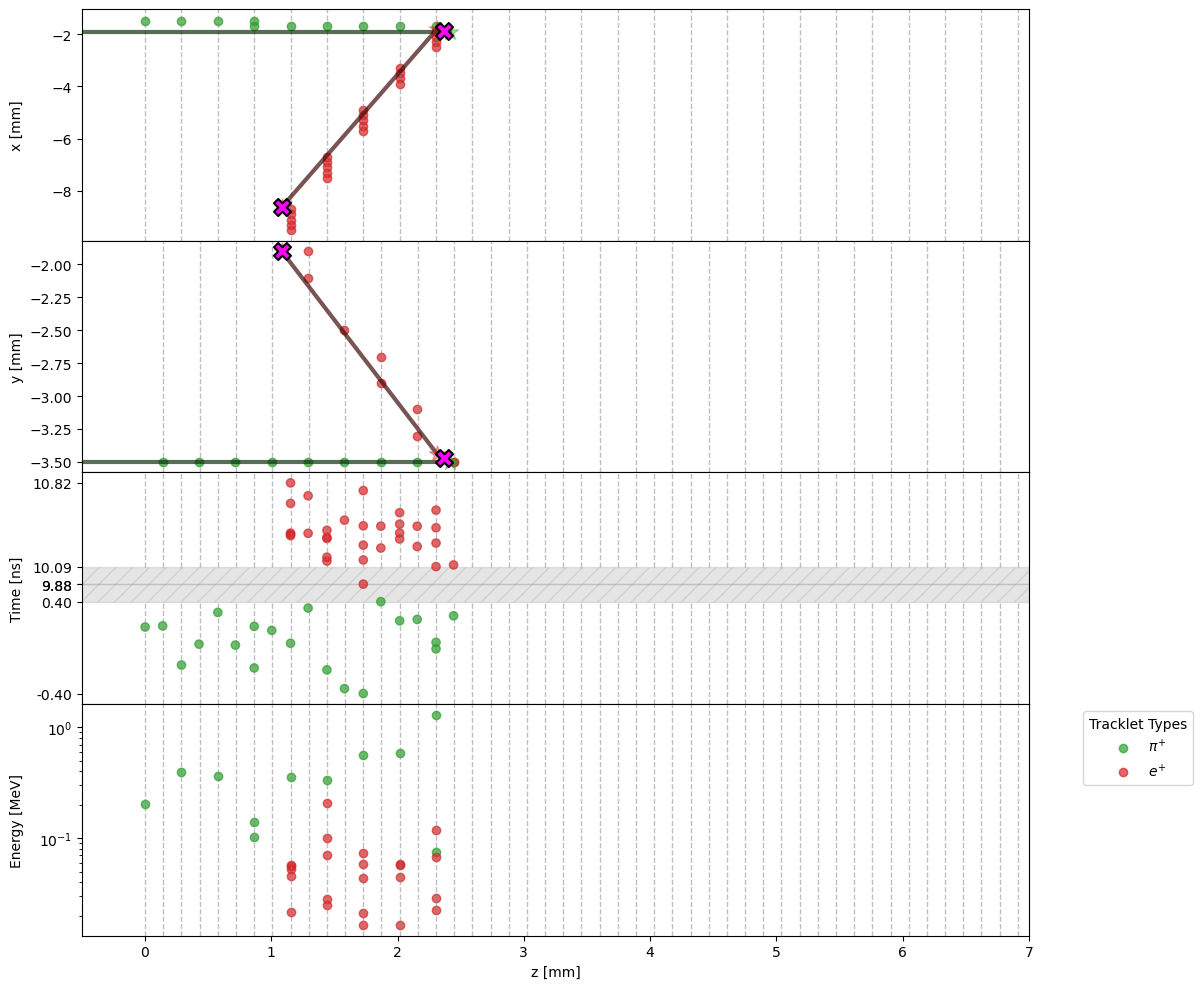

Extra event info:
{'stage': <Stage.VERTICES_FORMED: 2>, 'tracklet_algorithm_info': {'n_patterns_truth': 1, 'particles_in_event_truth': Counter({211: 1, -11: 1}), 'patterns_truth': {0: [0, 1]}}, 'vertex_algorithm_info': {'vertex_comparison': {'front_vertices': {Vertex(id=1, num_tracklets=1), Vertex(id=2, num_tracklets=2), Vertex(id=0, num_tracklets=1)}, 'back_vertices': {Vertex(id=0, num_tracklets=1), Vertex(id=1, num_tracklets=2), Vertex(id=2, num_tracklets=1)}, 'both_vertices': {Vertex(id=1, num_tracklets=1), Vertex(id=0, num_tracklets=2), Vertex(id=2, num_tracklets=1)}}, 'stats': {'front': {'BIC': 10.158363343361327, 'k': 3, 'centroids': array([[-8.62360563e+00,  0.00000000e+00,  1.08250000e+00],
       [-1.44633437e+00,  0.00000000e+00, -3.48031458e+13],
       [-1.86658597e+00,  0.00000000e+00,  2.36411853e+00]]), 'iteration': 2, 'all_iterations': [{'bic': 208818874751354.97, 'k': 1, 'vertices': array([[-3.45077799e+00,  0.00000000e+00, -8.70078645e+12]]), 'iteration': 1}, {'bic': 

In [9]:
# Choose a vertex forming algorithm, I'm using this kmeans one, but you can write your own child class of VertexFormer
from algorithms.vertex.kmeans_vertex_former_given_endpoints import KMeansVertexFormerGivenEndpoints
event_patterns.vertex_former = KMeansVertexFormerGivenEndpoints()

event_patterns.form_vertices()

reload(plotting_utils)
plotting_utils.plot_event(event_patterns)

# See the extra info stored at this point
print("Extra event info:")
print(event_patterns.extra_info)

## Create Patterns from Vertices

In [10]:
# Choose a pattern forming algorithm, I'm using this default one, but you can write your own child class of PatternFormer
from algorithms.pattern.default_pattern_former import DefaultPatternFormer
event_patterns.pattern_former = DefaultPatternFormer()
event_patterns.form_patterns()

# Print patterns and the unique tracklets within each pattern along with vertex information
patterns = event_patterns.get_patterns()
for pattern in patterns:
    print(f"\nPattern with {len(pattern.get_vertices())} vertices.")

    # Print info for each vertex in the pattern
    for vertex in pattern.get_vertices():
        tracklet_ids = [t.tracklet_id for t in vertex.get_tracklets()]
        print(f"  Vertex {vertex.vertex_id} (tracklet_ids={tracklet_ids})")

    print("  Unique Tracklets:")
    unique_tracklets = pattern.get_unique_tracklets()
    for tracklet in unique_tracklets:
        print(f"    {tracklet}")


# See the extra info stored at this point
print()
print("Extra event info:")
print(event_patterns.extra_info)


Pattern with 3 vertices.
  Vertex 1 (tracklet_ids=[0])
  Vertex 2 (tracklet_ids=[0, 1])
  Vertex 0 (tracklet_ids=[1])
  Unique Tracklets:
    Tracklet(id=0, particle_id=211, name=\pi^{+}, color=#2CA02C, e_id=1896, hits=20, extra_info_keys=None, endpoints=(Point3D(x=-1.4463343697395248, y=-3.3926687394790496, z=-34803145791889.43), Point3D(x=-1.9168086876196897, y=-3.499999999999979, z=2.41649002701341)))
    Tracklet(id=1, particle_id=-11, name=e^{+}, color=#D62728, e_id=1896, hits=31, extra_info_keys=None, endpoints=(Point3D(x=-8.623605629023437, y=-1.8999999761583466, z=1.0825000000000002), Point3D(x=-1.8163632585610665, y=-3.4390920175030497, z=2.311747027719356)))

Extra event info:
{'stage': <Stage.PATTERNS_FORMED: 3>, 'tracklet_algorithm_info': {'n_patterns_truth': 1, 'particles_in_event_truth': Counter({211: 1, -11: 1}), 'patterns_truth': {0: [0, 1]}}, 'vertex_algorithm_info': {'vertex_comparison': {'front_vertices': {Vertex(id=1, num_tracklets=1), Vertex(id=2, num_tracklets=2)

## (Optional) Validate Event Against Truth
This requires some truth information to be stored in the pattern's "extra_info". In this case, we stored it in the tracklet forming stage

In [11]:
# Choose a validation algorithm, I'm using one that checks that each pattern in the reco and truth contain the same tracklet ids
# but you can write your own child class of EventValidator
from algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator
event_patterns.validator = TrackletGroupingValidator(verbose = 1)
event_patterns.validate()


[Validation Success] All patterns validated successfully.


True

# Reconstruct Multiple Events

## Make cuts on the data set

In [12]:
# Number of events to process (set to None or a large number to process all events)
MAX_EVENTS = None
N_EVENTS = tree.GetEntries() if MAX_EVENTS is None else min(MAX_EVENTS, tree_pf.GetEntries())

use_pitar = True
use_in_fid_vol = True

nentries = tree.GetEntries()
all_events = []  # Store event IDs of all events that pass the initial cuts

for iEntry in tqdm(range(min(nentries, N_EVENTS)), desc="Processing Events"):

    patternFailed = False
    tree.GetEntry(iEntry)

    # SELECTIONS
    pitar = any(info.Has(r.kPitar) for info in tree.infoVec)

    if (not pitar) and use_pitar:
        continue

    in_fid_vol = True
    for tracklet in tree.trackletVec:
        for hit in tracklet.GetAllHits():
            vname = geoHelper.GetVolumeName(hit.GetVID()).Data()
            if 'atar' in vname:
                side = vname[11]
                if (side == "f" and abs(geoHelper.GetX(hit.GetVID())) > 8) or \
                   (side == "b" and abs(geoHelper.GetY(hit.GetVID())) > 8):
                    in_fid_vol = False

    if (not in_fid_vol) and use_in_fid_vol:
        continue

    all_events.append(iEntry)

Processing Events:   0%|          | 0/58403 [00:00<?, ?it/s]

## Run Reconstruction on Events

In [17]:
from algorithms.tracklet.reconstructed_tracklet_former import ReconstructedTrackletFormer
from algorithms.tracklet.default_tracklet_former import DefaultTrackletFormer

from algorithms.vertex.kmeans_vertex_former_given_endpoints import KMeansVertexFormerGivenEndpoints
from algorithms.vertex.kmeans_vertex_former import KMeansVertexFormer

from algorithms.pattern.default_pattern_former import DefaultPatternFormer

from algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator

# Preallocate array
reconstructed_events = np.empty(len(all_events), dtype=object)

# tqdm with simple progress description
with tqdm(total=len(all_events), desc="Reconstructing events") as pbar:
    for i, event_index in enumerate(all_events):
        event_patterns = EventPatterns(event_index, 
                                       DefaultTrackletFormer(truth_tree),
                                       #ReconstructedTrackletFormer(truth_tree), 
                                       KMeansVertexFormer(plane="front", planes_to_run={}, seed_method="random"),
                                       #KMeansVertexFormerGivenEndpoints(plane="front", planes_to_run={}, seed_method="random"), # Only run clustering using (x,z) info, speeds things up slightly 
                                       DefaultPatternFormer(), 
                                       TrackletGroupingValidator())
        event_patterns.form_all(tree, geoHelper, event_index)
        reconstructed_events[i] = event_patterns
        pbar.update(1)


Reconstructing events:   0%|          | 0/27795 [00:00<?, ?it/s]

# Check/View Algorithm Performance

## Performance vs. Particle composition

### Performance categorized by reconstructed particle componsition
Sometimes tracklets exist in truth, but do not create a hit in the atar. As a result, we cannot always construct the true particle composition.

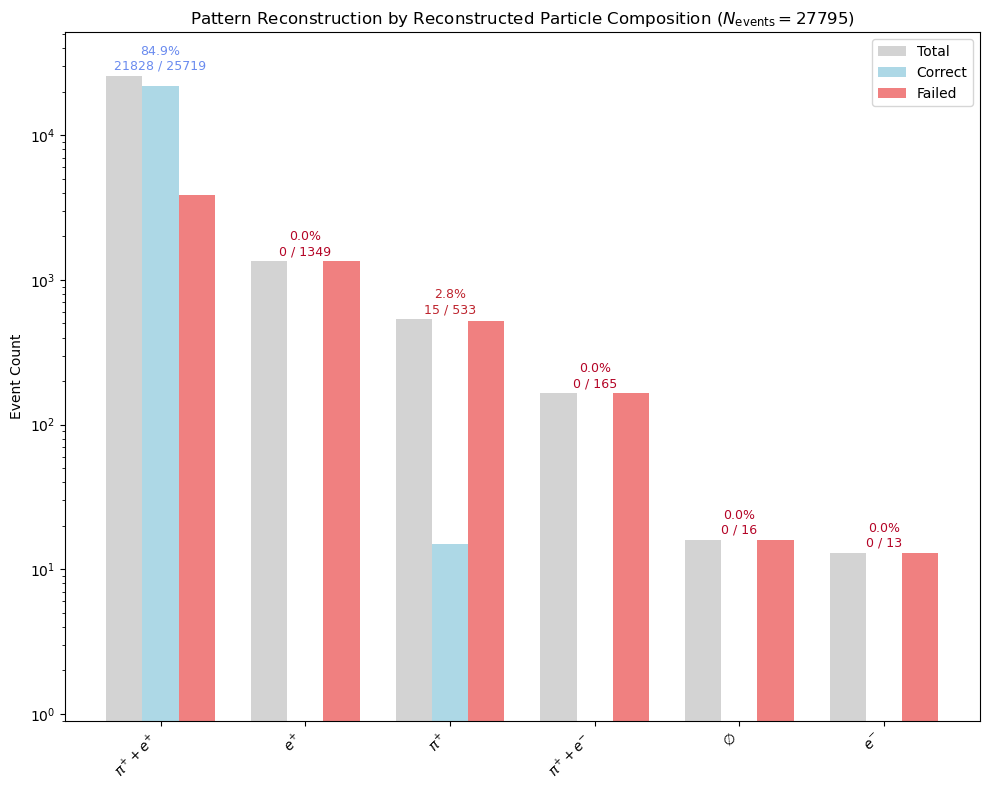

In [18]:
reload(plotting_utils)
title = f"Pattern Reconstruction by Reconstructed Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = False, title =  title)

### Performance categorized by true particle componsition
We can tag each event with the true particle composition information and plot against that instead to also see performance based on true particle composition

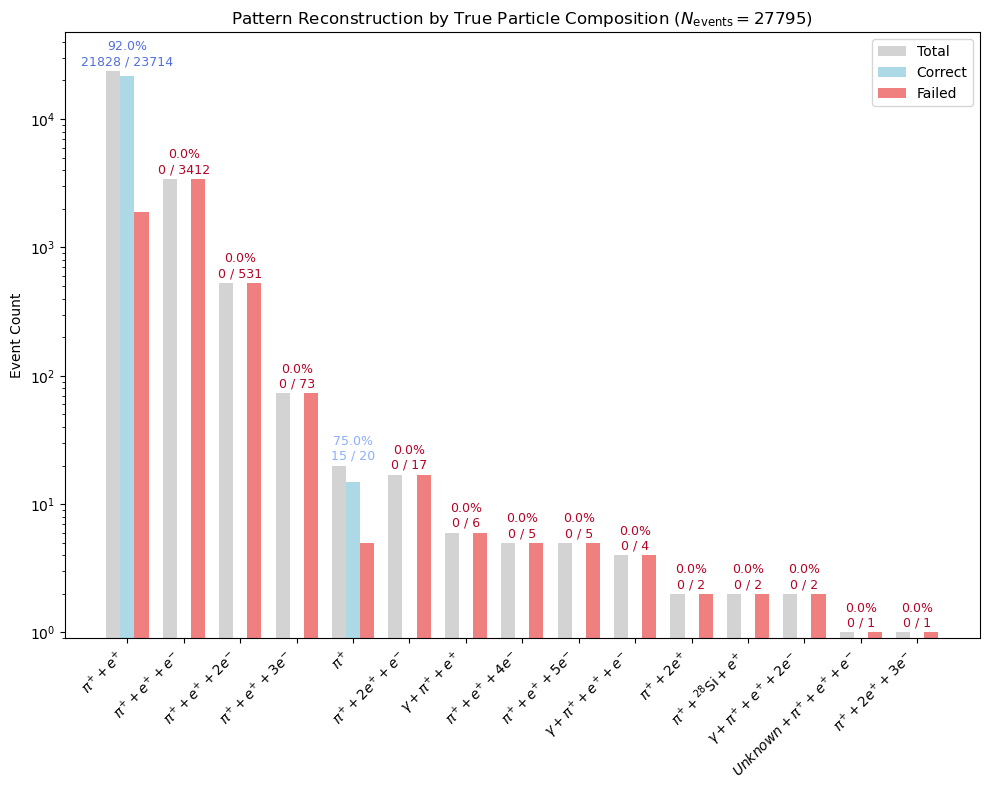

In [19]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = True, title =  title)

## Performance vs. True Number of Patterns

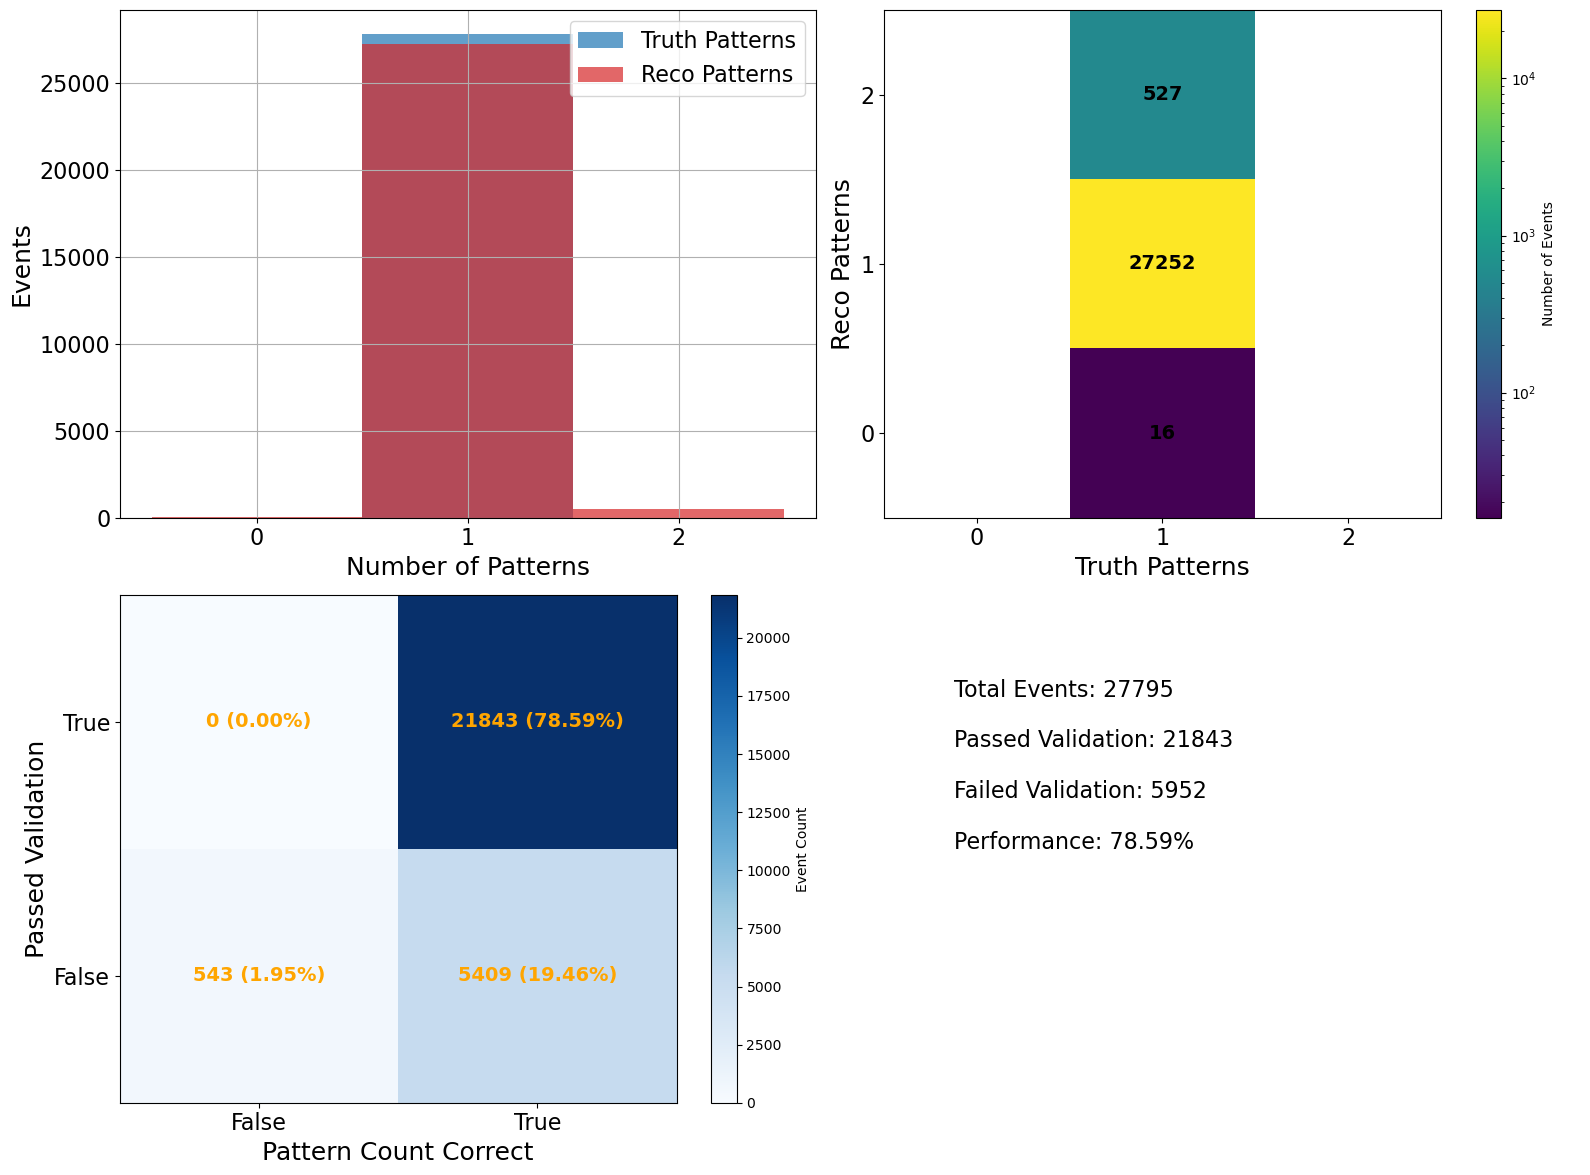

In [20]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_patterns_summary(reconstructed_events, title =  None)